[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Python-Financial-Analyst/pyfian_dev/blob/main/notebooks/fixed_income/00_economics_of_interest_rates.ipynb)

# Economics of Interest Rates

## Learning Objectives

By the end of this notebook, you will be able to:

- Identify and explain the key determinants of interest rates, including real risk-free rate, inflation premium, default risk premium, liquidity premium, maturity premium, and tax premium.
- Understand and apply the formula for calculating nominal interest rates as the sum of its components.
- Distinguish between nominal and real interest rates, and explain the significance of breakeven inflation.
- Retrieve and visualize historical data for nominal rates, real rates, breakeven inflation, and credit spreads using Python.
- Interpret the relationship between government bond yields, inflation expectations, and credit spreads in the context of financial markets.

## Installation

The following cell will install the `pyfian` package, which provides tools for financial analysis in Python. This step ensures that all necessary modules are available for the calculations and examples in this notebook.

In [ ]:
import importlib
import sys
import subprocess

try:
    importlib.import_module("pyfian")
except ImportError:
    print(f"Installing {"pyfian"}...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pyfian"])

try:
    importlib.import_module("pandas_datareader")
except ImportError:
    print(f"Installing {"pandas_datareader"}...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "git+https://github.com/pydata/pandas-datareader.git"])

## Determinants of Interest Rates

Interest rates are influenced by several key factors, often referred to as their determinants. Understanding these components helps explain why interest rates vary across different financial instruments and over time:

- **Real Risk-Free Rate:** This is the return on an investment with zero risk, excluding the effects of inflation. It reflects the pure time value of money for riskless securities.

- **Inflation Premium:** Lenders demand compensation for the expected loss of purchasing power due to inflation. The inflation premium is added to the real risk-free rate to offset anticipated inflation over the investment period.

- **Default Risk Premium:** This compensates lenders for the risk that a borrower may fail to make required payments. Securities with higher default risk, such as corporate bonds, typically offer a higher default premium compared to government securities.

- **Liquidity Premium:** Some investments are not easily converted to cash without significant loss of value. The liquidity premium compensates investors for the risk of holding less liquid assets.

- **Maturity (or Term) Premium:** Longer-term securities are exposed to greater interest rate risk and uncertainty. The maturity premium compensates investors for the additional risks associated with longer maturities.

- **Tax Premium:** Compensation for the tax treatment of interest rates (e.g., municipal bonds may have lower rates due to tax advantages).

The nominal interest rate on a security is generally the sum of these components, reflecting the total compensation required by investors.

## Formula for Nominal Interest Rates

The nominal interest rate ($r_{nom}$) is calculated as the sum of its key components:

$$
r_{\text{nom}} = r^\star + \pi + \text{Default} + \text{Liq} + \text{Mat} + \text{Tax}
$$

Where:
- $ r^\star $: Real risk-free rate
- $ \pi $: Inflation premium
- $ \text{Default} $: Default risk premium
- $ \text{Liq} $: Liquidity premium
- $ \text{Mat} $: Maturity (term) premium
- $ \text{Tax} $: Tax premium

Each term represents compensation for specific risks or factors that affect the overall interest rate.

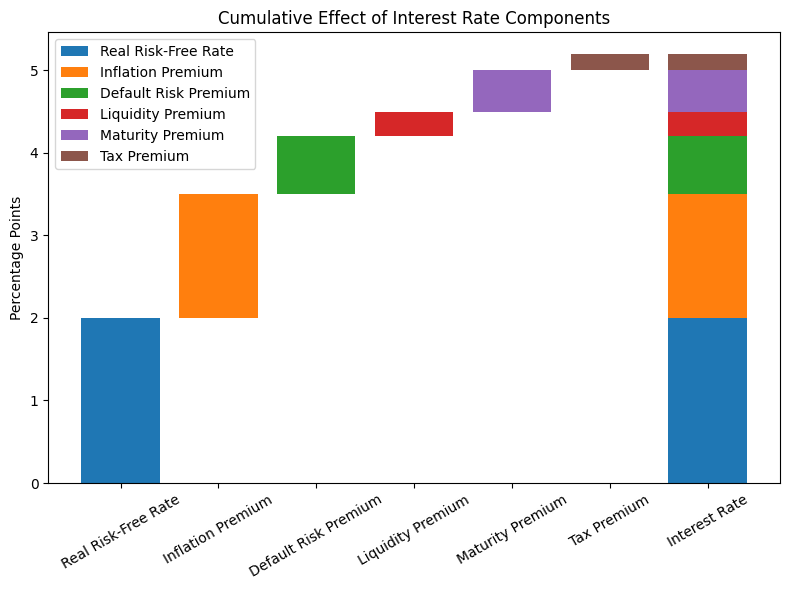

In [ ]:
import matplotlib.pyplot as plt

# Example values for each component (in percentage points)
components = {
    "Real Risk-Free Rate": 2.0,
    "Inflation Premium": 1.5,
    "Default Risk Premium": 0.7,
    "Liquidity Premium": 0.3,
    "Maturity Premium": 0.5,
    "Tax Premium": 0.2
}

labels = list(components.keys())
values = list(components.values())

# Calculate cumulative bottoms for stacking
bottoms = [0]
for v in values[:-1]:
    bottoms.append(bottoms[-1] + v)

fig, ax = plt.subplots(figsize=(8, 6))

cumulative_values = [sum(values[:i+1]) for i in range(len(values))]
# Plot individual bars for each component
for i, (label, value, bottom) in enumerate(zip(labels, values, bottoms)):
    ax.bar(label, value, bottom=cumulative_values[i-1] if i > 0 else 0)

# Plot each component as a stacked bar
for i, (label, value, bottom) in enumerate(zip(labels, values, bottoms)):
    ax.bar("Interest Rate", value, bottom=bottom, label=label, color=ax.patches[i].get_facecolor())


ax.set_ylabel("Percentage Points")
ax.set_title("Cumulative Effect of Interest Rate Components")
ax.legend()
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

## Real vs Nominal Rates

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as web

def download_and_prepare(start_date='2010-01-01'):
    # Download data from FRED
    rates = web.DataReader('DGS10', 'fred', start=start_date)
    real_rate = web.DataReader('DFII10', 'fred', start=start_date)
    credit_spread = web.DataReader('BAA10Y', 'fred', start=start_date)

    # Rename columns for clarity
    rates.rename(columns={'DGS10': 'Nominal Rate'}, inplace=True)
    real_rate.rename(columns={'DFII10': 'Real Rate'}, inplace=True)
    credit_spread.rename(columns={'BAA10Y': 'Credit Spread'}, inplace=True)

    # Concatenate data into a single DataFrame and calculate Breakeven Inflation
    data = pd.concat([rates, real_rate, credit_spread], axis=1)
    data['Breakeven Inflation'] = data['Nominal Rate'] - data['Real Rate']
    data.dropna(inplace=True)
    return data

def plot_rates(data):
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Nominal Rate'], label='10Y Treasury Nominal Rate', color='blue')
    plt.plot(data.index, data['Breakeven Inflation'], label='10Y Breakeven Inflation Rate', color='red')
    plt.plot(data.index, data['Real Rate'], label='10Y Real Rate', color='green')
    plt.title('10-Year Treasury Rates and Breakeven Inflation')
    plt.xlabel('Date')
    plt.ylabel('Rate (%)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_stacked_area(data):
    plt.figure(figsize=(12, 6))
    plt.stackplot(
        data.index,
        data['Real Rate'],
        data['Breakeven Inflation'],
        labels=['Real Rate', 'Breakeven Inflation'],
        colors=['green', 'red'],
        alpha=0.6
    )
    plt.plot(data.index, data['Nominal Rate'], label='Nominal Rate (Line)', color='blue', linewidth=2)
    plt.title('Nominal Rate as Sum of Breakeven Inflation and Real Rate')
    plt.xlabel('Date')
    plt.ylabel('Rate (%)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_combined_subplots(data):
    # Superimposed plot with twin y-axis (Nominal, Breakeven, Real + Credit Spread)
    fig, ax1 = plt.subplots(figsize=(12, 6))

    custom_dotted = (0, (0.5, 3))

    # Left y-axis: Nominal, Breakeven, Real
    ax1.plot(data.index, data['Nominal Rate'], label='Nominal Rate', color='blue', linestyle=custom_dotted)
    ax1.plot(data.index, data['Breakeven Inflation'], label='Breakeven Inflation', color='red', linestyle=custom_dotted)
    ax1.plot(data.index, data['Real Rate'], label='Real Rate', color='green', linestyle=custom_dotted)
    ax1.set_ylabel('Rate (%)')
    ax1.set_xlabel('Date')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    # Right y-axis: Credit Spread
    ax2 = ax1.twinx()
    ax2.plot(data.index, data['Credit Spread'], label="Moody's Baa Credit Spread", color='purple', linewidth=2, alpha=0.7, linestyle='--')
    ax2.set_ylabel('Credit Spread (%)')
    ax2.legend(loc='upper right')

    plt.title('10Y Treasury Rates and Moody\'s Baa Credit Spread (Superimposed)')
    plt.tight_layout()
    plt.show()

# Ejecutar
data = download_and_prepare()

The nominal interest rate represents the stated or face value return that investors receive on their investments, typically quoted without any adjustment for inflation. It reflects the total percentage return promised or paid to investors over a period of time. However, this nominal rate does not reveal the *true* purchasing power of the returns, since inflation erodes the value of money over time. 

An instrument that represent the Real Risk Free Rate is the Treasury Inflation-Protected Securities (TIPS). TIPS are designed to help investors protect their purchasing power. They pay a real rate of return, since the principal and interest payments are adjusted periodically based on actual inflation rates. In contrast, nominal Treasury securities pay a fixed return that doesn’t adjust for inflation.

While inflation expectations are not observable, what we can calculate the inflation premium. The inflation premium is the difference between nominal and real rates: how much more investors demand from a debtor when interest rates aren't inflation protected vs. when they are. This inflation premium is mostly the result of inflation expectations (but also captures the inflation risk premium, that is, the uncertainty about this expectation).


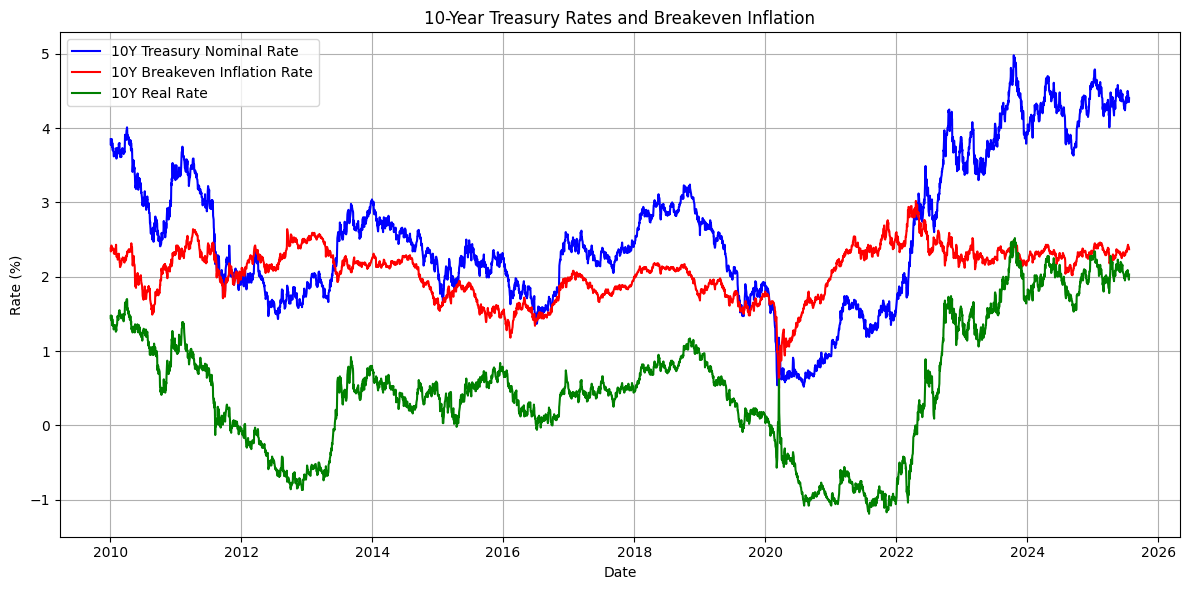

In [29]:
plot_rates(data)

This difference, called Breakeven inflation, is also the inflation rate that would equalize returns between a traditional nominal bond and an inflation-protected bond.

$$\text{Breakeven Inflation} = \text{Nominal Rate} - \text{Real Rate}$$

In practice, we calculate breakeven inflation as the difference between the yield on a nominal Treasury bond and the yield on a TIPS of the same maturity. If actual inflation turns out to be higher than the breakeven inflation rate, TIPS will outperform nominal Treasuries, since their payments adjust upwards with realized inflation.

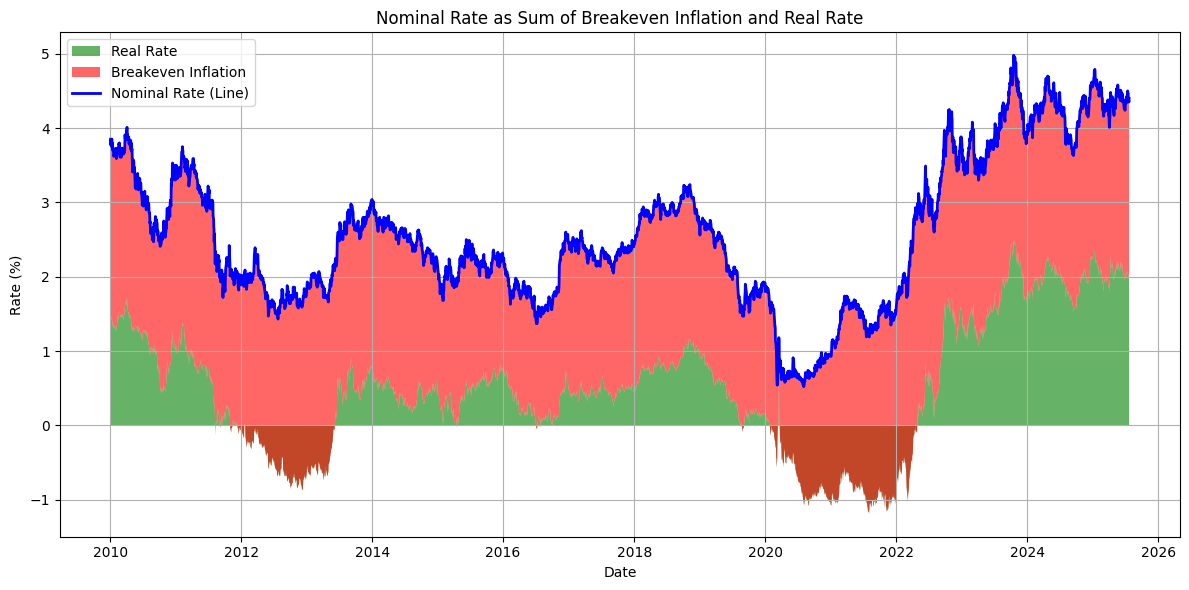

In [30]:
plot_stacked_area(data)

Looking at historical data, nominal rates and real rates have fluctuated significantly over time. In recent years, both have trended upwards. A key contributing factor to this rise has been persistently large government deficits, which can exert upward pressure on yields due to increased supply of government debt and potential concerns about inflation. This dynamic has led investors to demand higher compensation, both in nominal terms and increasingly in real terms, to hold government securities.

In summary, while the nominal rate is the headline figure often cited, understanding the real rate and breakeven inflation is essential for evaluating the true economic return on investments, especially in inflationary environments.

## Credit Spread

The credit spread refers to the difference in yield between a corporate bond (or any non-government security) and a comparable maturity risk-free government bond, such as a U.S. Treasury. This spread compensates investors for taking on credit risk, which is the possibility that the issuer might default on its payments. The yield on a corporate bond is therefore composed of two main parts:

$$\text{Nominal Yield on Corporate Bond} = \text{Risk-Free Nominal Rate} + \text{Credit Spread}$$

In this relationship, the risk-free nominal rate reflects the return on government bonds, while the credit spread represents the additional compensation investors require for bearing the risk of default. As credit conditions deteriorate or investors become more risk-averse, credit spreads tend to widen. Conversely, when economic conditions improve or investor appetite for risk increases, credit spreads typically narrow.

The Yield on Corporate Bond are nominal: their cash flows are fixed in nominal terms and do not adjust for inflation. However, inflation expectations can indirectly influence credit spreads. For example, if investors expect high inflation to pressure corporate profits or tighten financial conditions, credit spreads may widen to compensate for the increased risk.

In summary, credit spreads are an important component of nominal yields, reflecting credit risk, while real rates provide insight into inflation-adjusted returns. All three—nominal rates, real rates, and credit spreads—interact to reflect broader financial conditions, inflation expectations, and risk perceptions in the bond market.


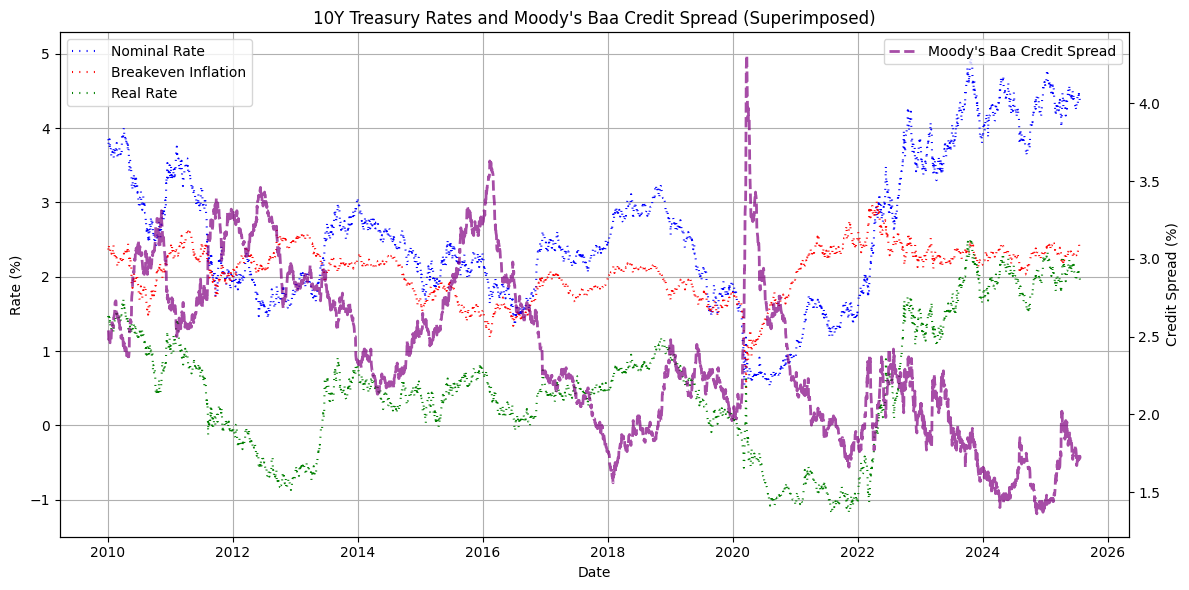

In [31]:
ax = plot_combined_subplots(data)